In [1]:
!pip install pytorch_model_summary

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision import models
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from pytorch_model_summary import summary

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Random Seed:  999


In [4]:
import os

# define the name of the directory to be created
vgg_w_path = "/content/vgg-weight"

try:
    os.mkdir(vgg_w_path)
except OSError:
    print ("Creation of the directory %s failed" % vgg_w_path)
else:
    print ("Successfully created the directory %s " % vgg_w_path)

Creation of the directory /content/vgg-weight failed


In [5]:
# 

In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/OCT/GAN/Data(Zip)/oct_normal.zip', 'r')
file = zip_ref.extractall("./tmp")
zip_ref.close()

print("o")

o


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/OCT/GAN/Data(Zip)/oct_normal_noise.zip', 'r')
file = zip_ref.extractall("./tmp2")
zip_ref.close()

print("o")

o


In [8]:
# Root directory for dataset
dataroot = '/content/tmp'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

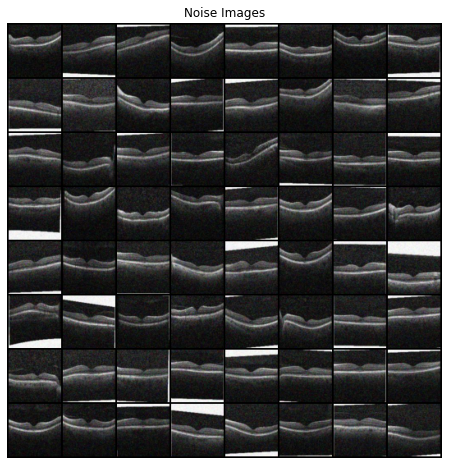

In [9]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
Noise_dataset = dset.ImageFolder(root='/content/tmp2/',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
Noise_dataloader = torch.utils.data.DataLoader(Noise_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some Noise images
noise_batch = next(iter(Noise_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Noise Images")
plt.imshow(np.transpose(vutils.make_grid(noise_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

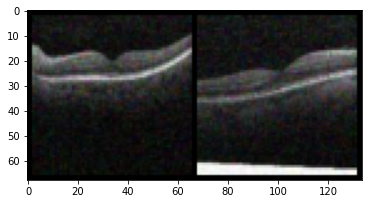

In [10]:
plt.imshow(np.transpose(vutils.make_grid(noise_batch[0].to(device)[:2], padding=2, normalize=True).cpu(),(1,2,0)))

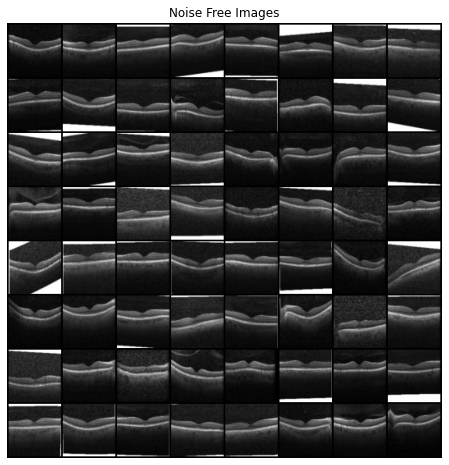

In [11]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
Noise__free_dataset = dset.ImageFolder(root='/content/tmp/',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
Noise__free_dataloader = torch.utils.data.DataLoader(Noise__free_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some Noise free images
real_batch = next(iter(Noise__free_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Noise Free Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

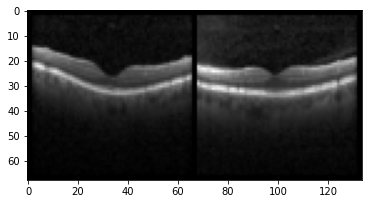

In [12]:
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:2], padding=2, normalize=True).cpu(),(1,2,0)))

In [13]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        self.encoder = nn.Sequential(

            nn.Conv2d(3, 32, 4, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 4, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 4, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 4, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            
        )

        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 256, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        x = self.encoder(input)
        x = self.decoder(x)

        return x




# # build model
print(summary(Generator(ngpu), torch.zeros((1, 3, 64, 64)), show_input=False))

---------------------------------------------------------------------------
         Layer (type)         Output Shape         Param #     Tr. Param #
             Conv2d-1      [1, 32, 61, 61]           1,568           1,568
        BatchNorm2d-2      [1, 32, 61, 61]              64              64
               ReLU-3      [1, 32, 61, 61]               0               0
          MaxPool2d-4      [1, 32, 30, 30]               0               0
             Conv2d-5      [1, 64, 27, 27]          32,832          32,832
        BatchNorm2d-6      [1, 64, 27, 27]             128             128
               ReLU-7      [1, 64, 27, 27]               0               0
          MaxPool2d-8      [1, 64, 13, 13]               0               0
             Conv2d-9     [1, 128, 10, 10]         131,200         131,200
       BatchNorm2d-10     [1, 128, 10, 10]             256             256
              ReLU-11     [1, 128, 10, 10]               0               0
         MaxPool2d-12   

In [15]:
# class UNet_down_block(torch.nn.Module):
#     def __init__(self, input_channel, output_channel, down_size):
#         super(UNet_down_block, self).__init__()
#         self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
#         self.bn1 = torch.nn.BatchNorm2d(output_channel)
#         self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
#         self.bn2 = torch.nn.BatchNorm2d(output_channel)
#         self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
#         self.bn3 = torch.nn.BatchNorm2d(output_channel)
#         self.max_pool = torch.nn.MaxPool2d(2, 2)
#         self.relu = torch.nn.ReLU()
#         self.down_size = down_size

#     def forward(self, x):
#         if self.down_size:
#             x = self.max_pool(x)
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.relu(self.bn2(self.conv2(x)))
#         x = self.relu(self.bn3(self.conv3(x)))
#         return x

# class UNet_up_block(torch.nn.Module):
#     def __init__(self, prev_channel, input_channel, output_channel):
#         super(UNet_up_block, self).__init__()
#         self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
#         self.conv1 = torch.nn.Conv2d(prev_channel + input_channel, output_channel, 3, padding=1)
#         self.bn1 = torch.nn.BatchNorm2d(output_channel)
#         self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
#         self.bn2 = torch.nn.BatchNorm2d(output_channel)
#         self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
#         self.bn3 = torch.nn.BatchNorm2d(output_channel)
#         self.relu = torch.nn.ReLU()

#     def forward(self, prev_feature_map, x):
#         x = self.up_sampling(x)
#         x = torch.cat((x, prev_feature_map), dim=1)
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.relu(self.bn2(self.conv2(x)))
#         x = self.relu(self.bn3(self.conv3(x)))
#         return x


# class Generator(torch.nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu

#         self.down_block1 = UNet_down_block(3, 16, False)
#         self.down_block2 = UNet_down_block(16, 32, True)
#         self.down_block3 = UNet_down_block(32, 64, True)
#         self.down_block4 = UNet_down_block(64, 128, True)
#         self.down_block5 = UNet_down_block(128, 256, True)
#         self.down_block6 = UNet_down_block(256, 512, True)
#         self.down_block7 = UNet_down_block(512, 1024, True)

#         self.mid_conv1 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
#         self.bn1 = torch.nn.BatchNorm2d(1024)
#         self.mid_conv2 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
#         self.bn2 = torch.nn.BatchNorm2d(1024)
#         self.mid_conv3 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
#         self.bn3 = torch.nn.BatchNorm2d(1024)

#         self.up_block1 = UNet_up_block(512, 1024, 512)
#         self.up_block2 = UNet_up_block(256, 512, 256)
#         self.up_block3 = UNet_up_block(128, 256, 128)
#         self.up_block4 = UNet_up_block(64, 128, 64)
#         self.up_block5 = UNet_up_block(32, 64, 32)
#         self.up_block6 = UNet_up_block(16, 32, 16)

#         self.last_conv1 = torch.nn.Conv2d(16, 16, 3, padding=1)
#         self.last_bn = torch.nn.BatchNorm2d(16)
#         self.last_conv2 = torch.nn.Conv2d(16, 3, 1, padding=0)
#         self.relu = torch.nn.ReLU()

#     def forward(self, x):
#         self.x1 = self.down_block1(x)
#         self.x2 = self.down_block2(self.x1)
#         self.x3 = self.down_block3(self.x2)
#         self.x4 = self.down_block4(self.x3)
#         self.x5 = self.down_block5(self.x4)
#         self.x6 = self.down_block6(self.x5)
#         self.x7 = self.down_block7(self.x6)
#         self.x7 = self.relu(self.bn1(self.mid_conv1(self.x7)))
#         self.x7 = self.relu(self.bn2(self.mid_conv2(self.x7)))
#         self.x7 = self.relu(self.bn3(self.mid_conv3(self.x7)))
#         x = self.up_block1(self.x6, self.x7)
#         x = self.up_block2(self.x5, x)
#         x = self.up_block3(self.x4, x)
#         x = self.up_block4(self.x3, x)
#         x = self.up_block5(self.x2, x)
#         x = self.up_block6(self.x1, x)
#         x = self.relu(self.last_bn(self.last_conv1(x)))
#         x = self.last_conv2(x)
#         return x

# # build model
# print(summary(Generator(ngpu), torch.zeros((1, 3, 64, 64)), show_input=False))

In [16]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)

In [17]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [18]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [19]:
class VGG_MODEL():

    def __init__(self, vgg_w_path):
        self.vgg_w_path = vgg_w_path 
        torch.utils.model_zoo.load_url('https://download.pytorch.org/models/vgg19-dcbb9e9d.pth', model_dir = self.vgg_w_path)
        

    def model(self):
        vgg = models.vgg19()
        vgg.load_state_dict(torch.load('/content/vgg-weight/vgg19-dcbb9e9d.pth'))

        for param in vgg.parameters():
            param.requires_grad_(False)

        for i, layer in enumerate(vgg.features):
            if isinstance(layer, torch.nn.MaxPool2d):
                vgg.features[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        
        return vgg.features


In [20]:
vgg = VGG_MODEL(vgg_w_path)
print(vgg.model())

print(summary(vgg.model(), torch.zeros((1, 3, 224, 224)), show_input=False))

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256

In [21]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
noise_itr = next(iter(Noise_dataloader))
fixed_noise = noise_itr[0].to(device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [22]:
mse_criterion = torch.nn.MSELoss(reduction='mean')

def extract_features(model, x, layers):
    features = list()
    for index, layer in enumerate(model):
        # print(index, layer)
        x = layer(x)
        if index in layers:
            features.append(x)
    return features

def calc_Content_Loss(features, targets, weights=None):
    if weights is None:
        weights = [1/len(features)] * len(features)
    
    content_loss = 0
    for f, t, w in zip(features, targets, weights):
        content_loss += mse_criterion(f, t) * w
        
    return content_loss


In [23]:

# Lists to keep track of progress
img_list = []
img_list_all = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(20):
   



    p_loss_network = vgg.model().to(device)
    # p_loss_network = models.vgg19(pretrained=True).features.to(device)
    # print(p_loss_network)


    i = 0
    for  data_noise, data_noise_free in zip(Noise_dataloader, Noise__free_dataloader):
        i = i + 1
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data_noise_free[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = data_noise[0].to(device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

       
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)


        ########## Perceptual loss ##################
        X = extract_features(p_loss_network, real_cpu, layers=[16])
        Y = extract_features(p_loss_network, noise, layers=[16])

        content_loss = calc_Content_Loss(Y, X)


        # Calculate G's loss based on this output
        adver_loss = criterion(output, label)

        # adversarial + content 
        errG = content_loss * 1 + adver_loss

        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()

        
        # Update G
        optimizerG.step()


        

        # Output training stats
        if i % 25 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(Noise_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 250 == 0) or ((epoch == num_epochs-1) and (i == len(Noise_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                # fake = fake[0]
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            img_list_all.append(fake)
            print("data append")

        iters += 1

Starting Training Loop...
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, pad

In [24]:
ss

NameError: ignored

In [ ]:
# PATH_D = '/content/drive/MyDrive/model_weights(D).pth'
# PATH_G = '/content/drive/MyDrive/model_weights(G).pth'
# torch.save(netD, PATH_D)
# torch.save(netG, PATH_G)

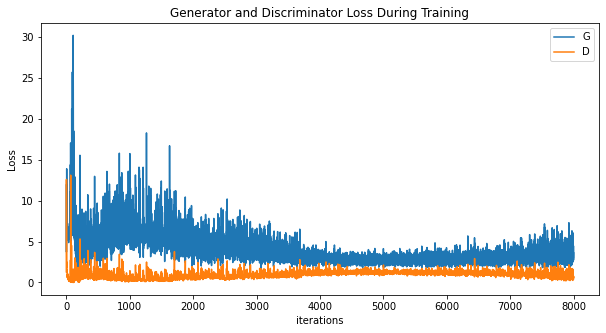

In [25]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

ValueError: ignored

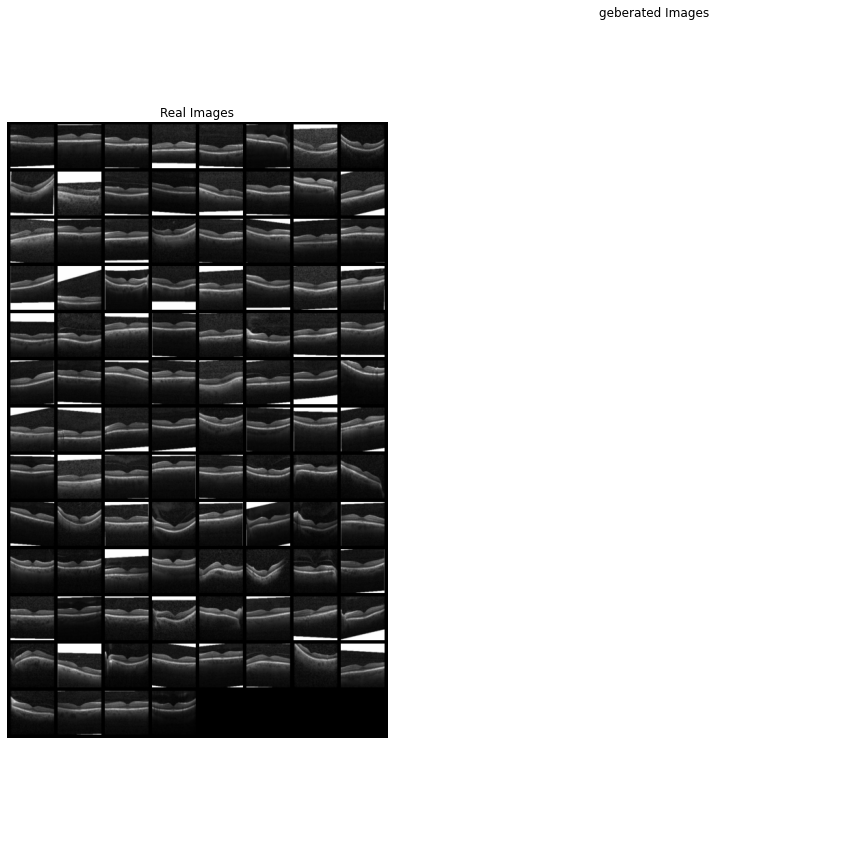

In [35]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(Noise__free_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:100], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("geberated Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [28]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [29]:
for i ,img_batch in enumerate(real_batch[0]):
    print(i)
    if i > 12:
        for i, img in enumerate(img_batch):
            img_list = vutils.make_grid(img, padding=2, normalize=True)
            # Plot the fake images from the last epoch
            plt.subplot(1,2,2)
            plt.axis("off")
            plt.title("Real Images")
            plt.imshow(np.transpose(img_list,(1,2,0)))
            plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [31]:
for i ,img_batch in enumerate(img_list_all):
    print(i)
    if i > 31:
        for i, img in enumerate(img_batch):
            img_list = vutils.make_grid(img, padding=2, normalize=True)
            # Plot the fake images from the last epoch
            plt.subplot(1,2,2)
            plt.axis("off")
            plt.title("generated Images")
            plt.imshow(np.transpose(img_list,(1,2,0)))
            plt.show()

Output hidden; open in https://colab.research.google.com to view.

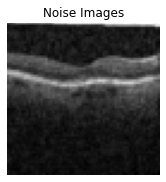

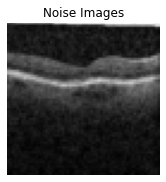

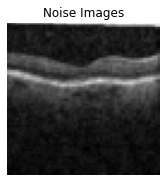

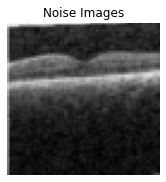

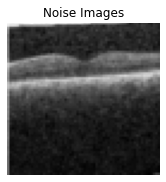

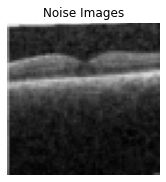

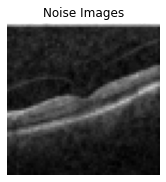

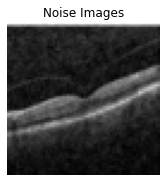

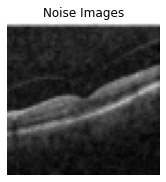

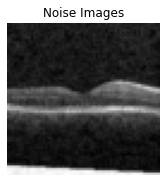

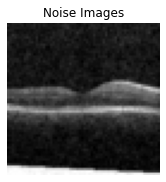

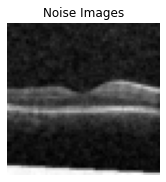

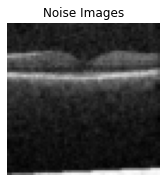

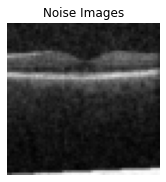

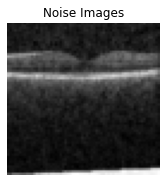

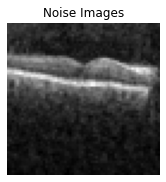

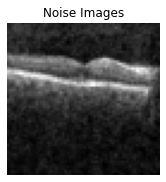

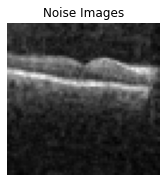

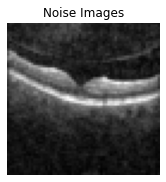

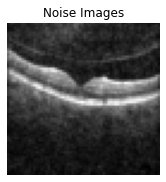

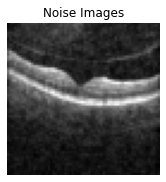

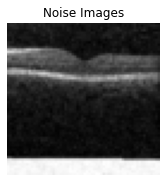

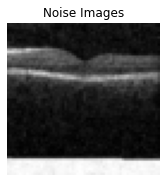

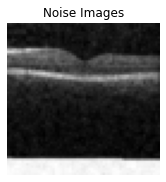

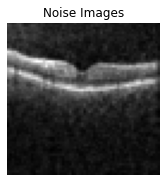

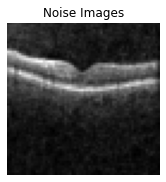

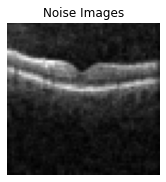

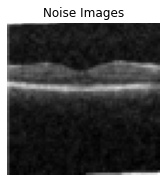

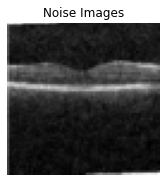

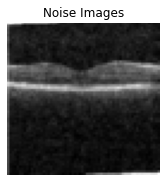

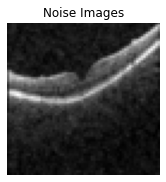

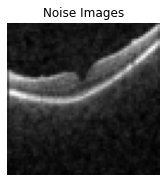

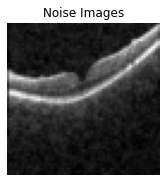

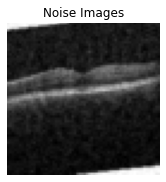

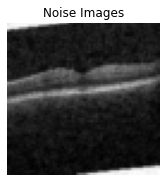

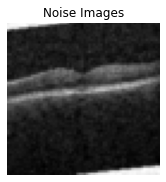

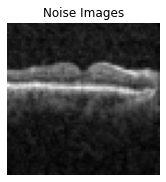

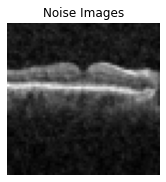

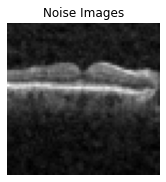

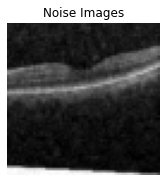

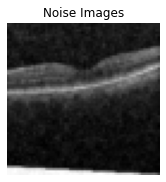

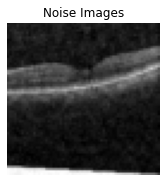

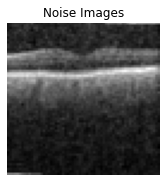

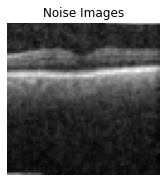

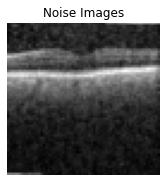

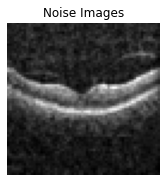

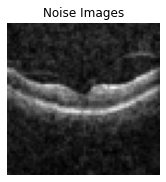

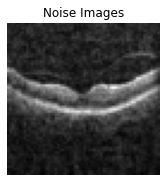

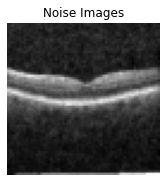

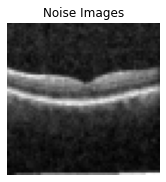

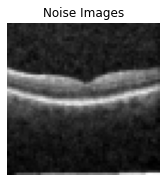

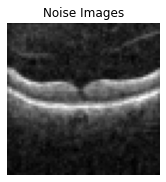

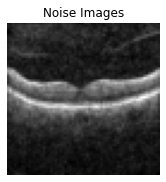

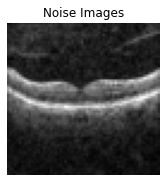

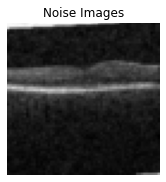

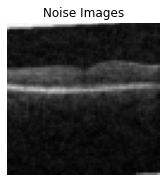

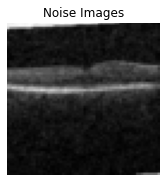

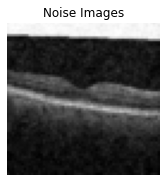

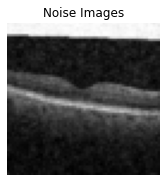

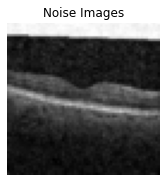

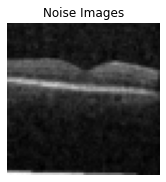

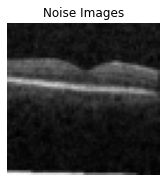

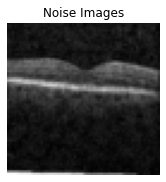

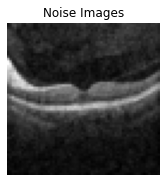

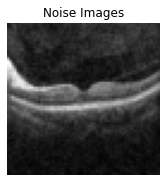

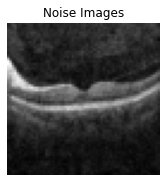

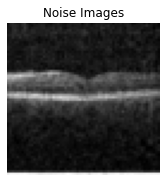

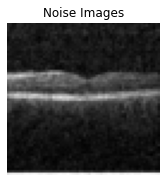

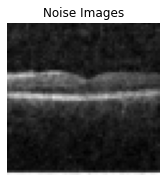

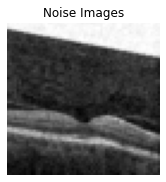

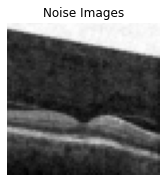

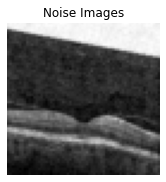

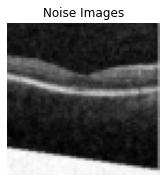

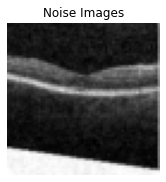

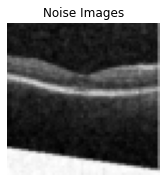

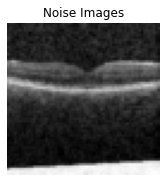

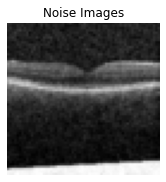

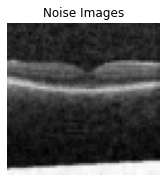

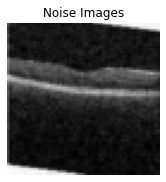

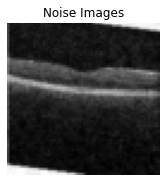

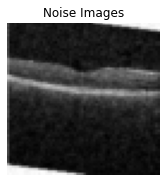

In [33]:
# Grab a batch of real images from the dataloader
noise_batch = next(iter(Noise_dataloader))

# # Plot the real images
# plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.axis("off")
# plt.title("Noise Images")
# plt.imshow(np.transpose(vutils.make_grid(noise_batch[0].to(device)[:100], padding=5, normalize=True).cpu(),(1,2,0)))

for i ,img_batch in enumerate(noise_batch[0]):
    # print(i)
    if i > 100:
        for i, img in enumerate(img_batch):
            img_list = vutils.make_grid(img, padding=2, normalize=True)
            # Plot the fake images from the last epoch
            plt.subplot(1,2,2)
            plt.axis("off")
            plt.title("Noise Images")
            plt.imshow(np.transpose(img_list,(1,2,0)))
            plt.show()

In [ ]:
import pickle



with open('/content/drive/MyDrive/img_list.pickle', 'wb') as handle:
    pickle.dump(img_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# print a == b

In [ ]:
transform1 =transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

In [ ]:
import cv2
from PIL import Image
path = '/content/8.jpg'
img = Image.open(path)
# img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# img=cv2.resize(img,(224,224))  
# print(img.shape)


img = transform1(img)
img.shape

In [ ]:
test_image = img.view(1, img.shape[0], img.shape[1], img.shape[2])
test_image.shape

In [ ]:
test_out = netG(test_image.to(device)).detach().cpu()
test_out.shape

In [ ]:
# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.imshow(np.transpose(test_out[-1],(1,2,0)))
plt.show()

In [ ]:

def im_convertNumpy(tensor):
    image = tensor.clone().detach().numpy()
    image = image.reshape((64, 64, 3))
    #image = image.transpose(-1,1, 2, 0)
    print(image.shape)
    # image = image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image = image.clip(0,1)
    return image



out_img = im_convertNumpy(test_out)
plt.imshow(out_img)
# dataiter = iter(training_loader)
# images, labels = dataiter.next()

# fig=plt.figure(figsize=(25,4))
# for idx in np.arange(20):
#     ax = fig.add_subplot(2,10,idx+1)
#     plt.imshow(im_convertNumpy(images[idx]))
#     ax.set_title([labels[idx].item()])
# plt.show()

In [ ]:
noise_itr = next(iter(Noise_dataloader))
fixed_noise = noise_itr[0].to(device)

In [ ]:
fake = netG(fixed_noise.to(device)).detach().cpu()

In [ ]:
fake.shape

In [ ]:
# for img in fake:
#     plt.imshow(np.transpose(img,(1,2,0)))
#     plt.show()


In [ ]:
for img in img_list:
    print(np.array(img).shape)

In [ ]:
# for img_batch in img_list_all[-1]:
#     for img in fake:
#         out = np.transpose(img,(1,2,0))
#         image = out.clip(0,1)
#         plt.imshow(image )
#         plt.show()

In [ ]:
# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fake[-1],(1,2,0)))
plt.show()